# Сравнение поисковых деревьев
### Выполнили Вихрев И., Репин В. гр 382006-3м

In [23]:
import sys
from pathlib import Path
import random
import time
import statistics as stat
sys.path.append(str(Path.cwd().resolve()/'python_bindings'))
import trees

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style = 'whitegrid', rc={'figure.figsize':(20, 10)})

In [25]:
dir(trees)

['AVLTreeInt',
 'AVLTreeString',
 'RBTreeInt',
 'RBTreeString',
 'SortedArrInt',
 'SortedArrString',
 'SplayTreeInt',
 'SplayTreeString',
 'TreapInt',
 'TreapString',
 '__builtins__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__test__']

In [26]:
def evaluate(tree, unique_set, count_rot = False):
    total = 0
    insert_time = []
    search_time = []
    delete_time = []
    rotations_count = []
    
    # insertion and searching time
    start_total = time.time_ns()
    for idx, n in enumerate(unique_set):
        
        start = time.time_ns()
        tree.insert(n)
        end = time.time_ns()
        
        insert_time.append(end-start)
        if(count_rot):
            rotations_count.append(tree.rotations_num)
        
        start = time.time_ns()
        tree.search(unique_set[random.randrange(idx+1)])
        end = time.time_ns()
        
        search_time.append(end-start)
    end_total = time.time_ns()
    total += end_total - start_total
    
    # deletion time
    shuffled_set = random.sample(unique_set, len(unique_set))
    
    start_total = time.time_ns()
    for idx in range(0, len(unique_set)):
        
        start = time.time_ns()
        tree.delete(shuffled_set[idx])
        end = time.time_ns()
        
        delete_time.append(end-start)
    end_total = time.time_ns()
    delete_time.reverse()
    
    # scale ns to ms
    insert_time  = [element * 10**(-6) for element in insert_time]
    search_time  = [element * 10**(-6) for element in search_time]
    delete_time  = [element * 10**(-6) for element in delete_time]
    print(f'Insert, Mean : {stat.mean(insert_time):.6f} ms.,  Max {max(insert_time):.6f} ms.')
    print(f'Search, Mean : {stat.mean(search_time):.6f} ms.,  Max {max(search_time):.6f} ms.')
    print(f'Delete, Mean : {stat.mean(delete_time):.6f} ms.,  Max {max(delete_time):.6f} ms.')
    print(f'Total time {(total + end_total-start_total)*10**(-9):.6f}, sec')
    return (insert_time, search_time, delete_time, rotations_count)

In [67]:
unique_num_set = random.sample(range(0, 10**8), 10**7)
num = range(0, len(unique_num_set))

# splay tree

Двоичное дерево поиска, в котором поддерживается свойство сбалансированности. Особенностью является то, что при каждом обращении к дереву вызывается функция splay(x) - перемещение элемента x к корню дерева. Амортизированное время выполнения основных операций(вставка, поиск, удаление) - O(log(n))

In [28]:
insert_time, search_time, delete_time, _ = evaluate(trees.SplayTreeInt(), unique_num_set)

Insert, Mean : 0.002618 ms.,  Max 15.840300 ms.
Search, Mean : 0.003443 ms.,  Max 15.773300 ms.
Delete, Mean : 0.003573 ms.,  Max 79.006000 ms.
Total time 104.304778, sec


### Insertion

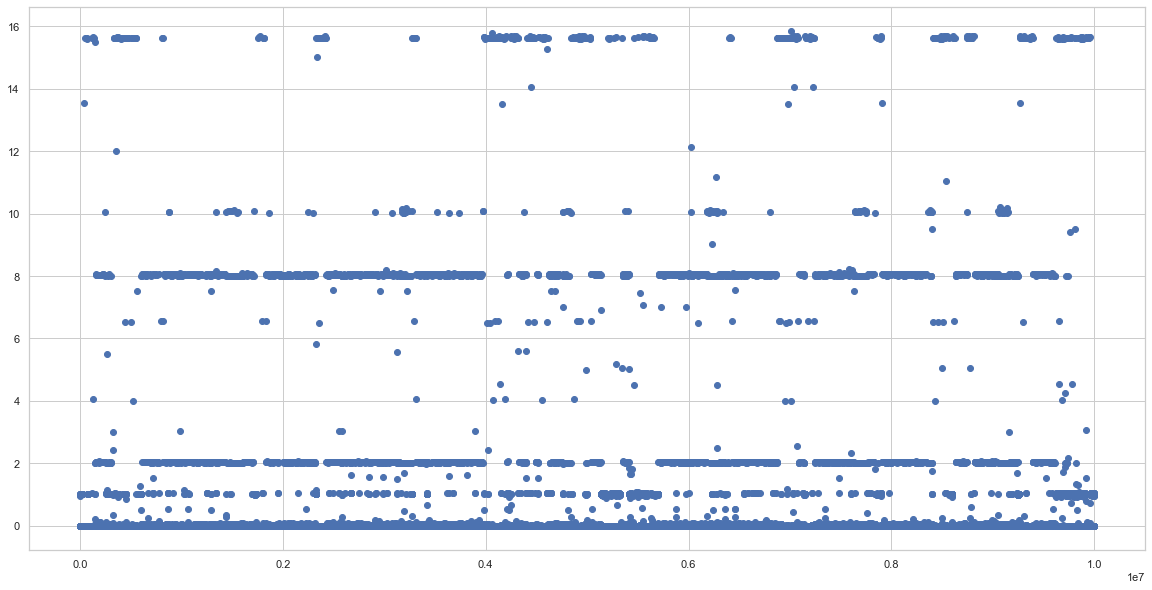

In [29]:
plt.scatter(num, insert_time)
pass

### Searching

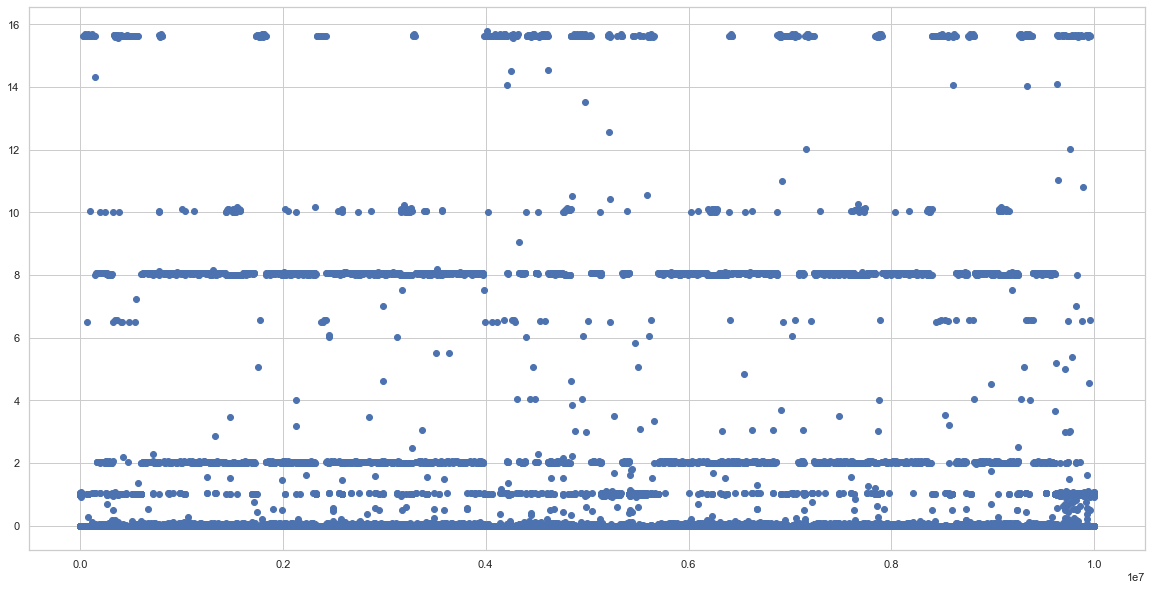

In [30]:
plt.scatter(num, search_time)
pass

### Deletion

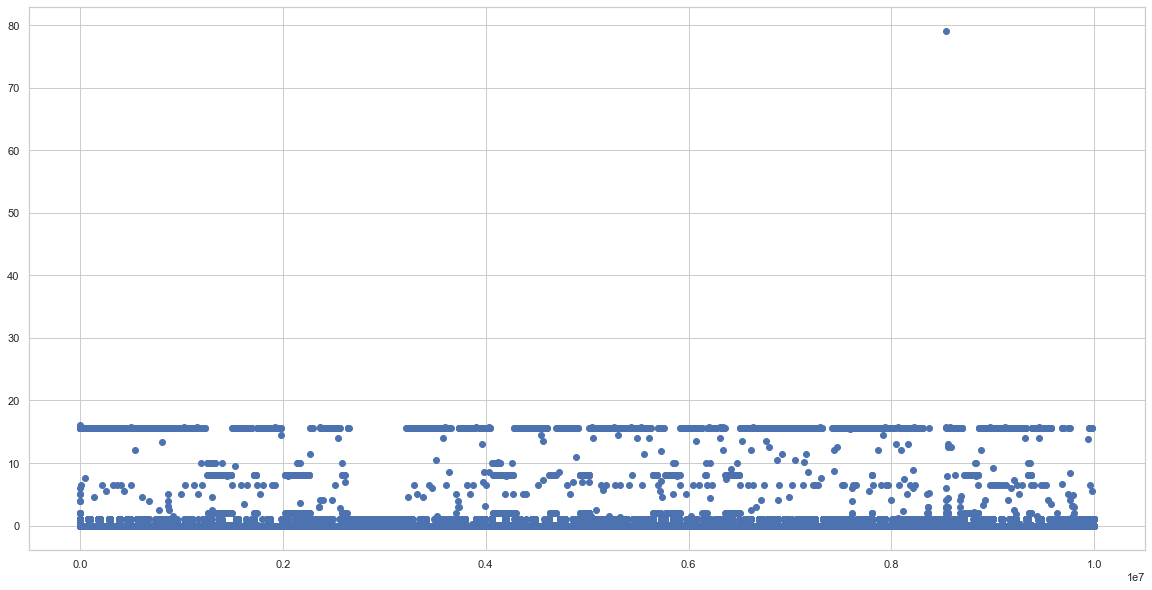

In [31]:
plt.scatter(num, delete_time)
pass

# AVL tree

Сбалансированное двоичное дерево поиска, в котором поддерживается следующее свойство: для каждой его вершины высота её двух поддеревьев различается не более чем на 1. Среднее время выполнения основных операций O(log(n))

In [68]:
insert_time, search_time, delete_time, rotations_count = evaluate(trees.AVLTreeInt(), unique_num_set, True)

Insert, Mean : 0.003264 ms.,  Max 15.682000 ms.
Search, Mean : 0.003313 ms.,  Max 15.679400 ms.
Delete, Mean : 0.004090 ms.,  Max 53.000900 ms.
Total time 118.510279, sec


### Rotations

Количество поворотов при вставке:

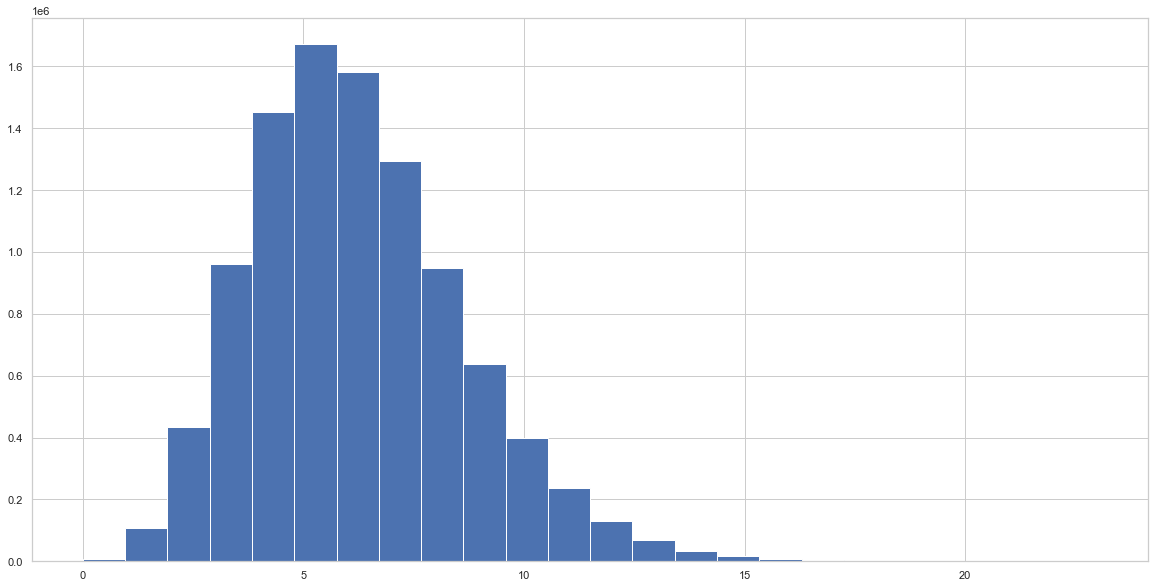

In [69]:
plt.hist(rotations_count, bins = len(set(rotations_count)) )
pass

In [70]:
max(rotations_count)

23

### Insertion

Как видно из графика, времена вставки разбиваются на несколько уровней, в зависимости от того, сколько поворотов необходимо было совершить для балансировки дерева.

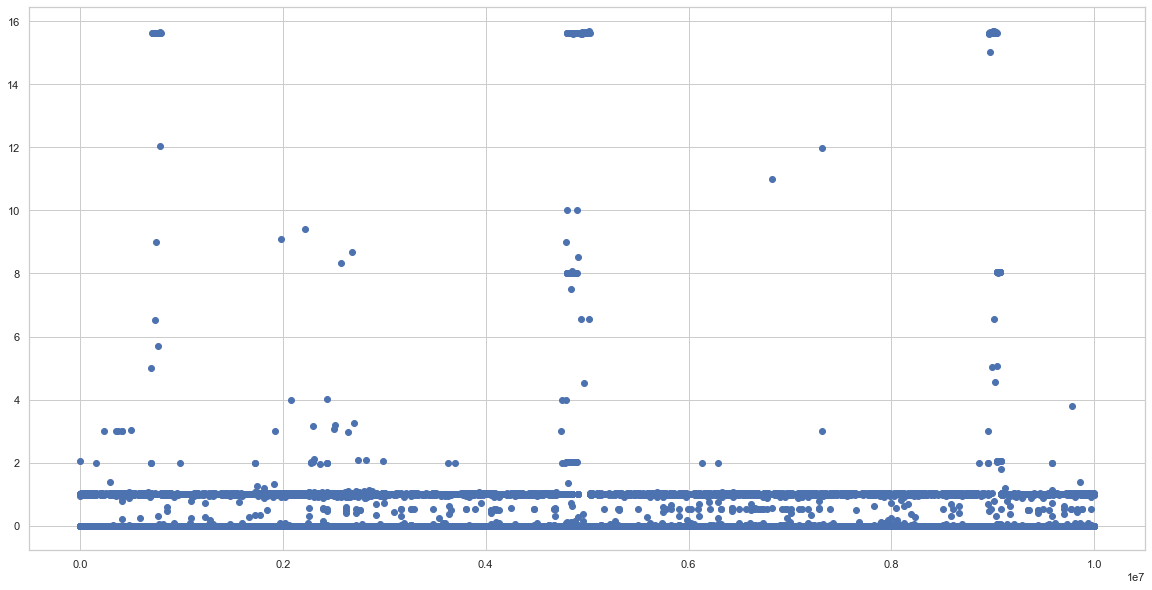

In [71]:
plt.scatter(num, insert_time)
pass

In [72]:
rnum = len(set(rotations_count))

In [73]:
hue_rotations  = [0 if element <= rnum/5 else 1 for element in rotations_count]

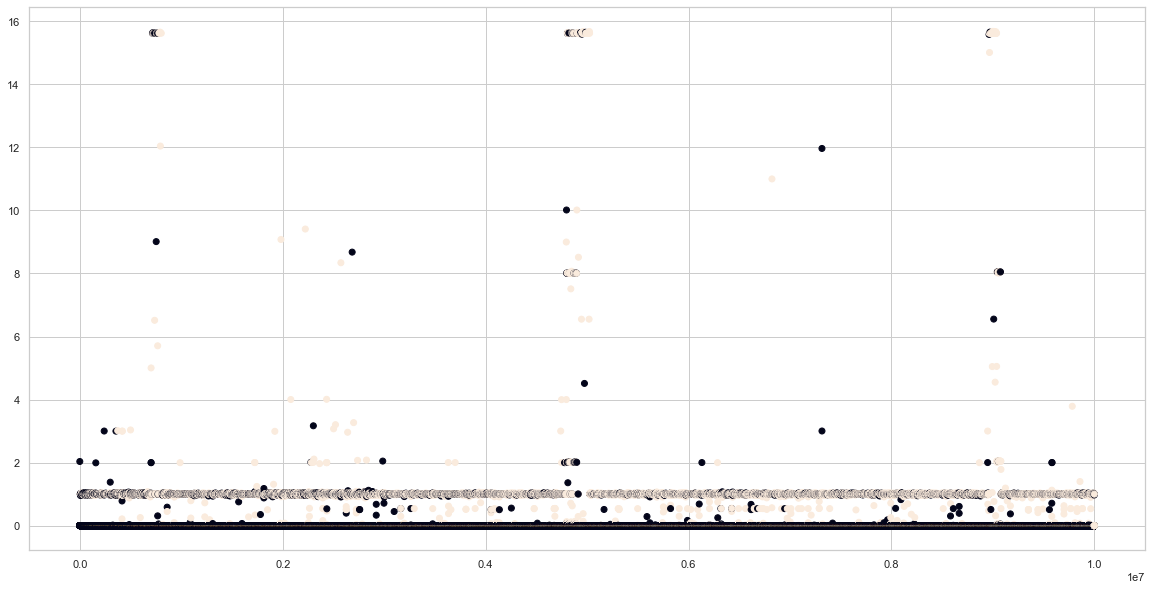

In [74]:
plt.scatter(num, insert_time, c = hue_rotations)
pass

### Searching

Здесь мы также наблюдаем разбиение времени поиска одного элемента по "уровням", в данном случае уровни соответствуют глубине поиска - насколько далеко от корня расположен искомый элемент

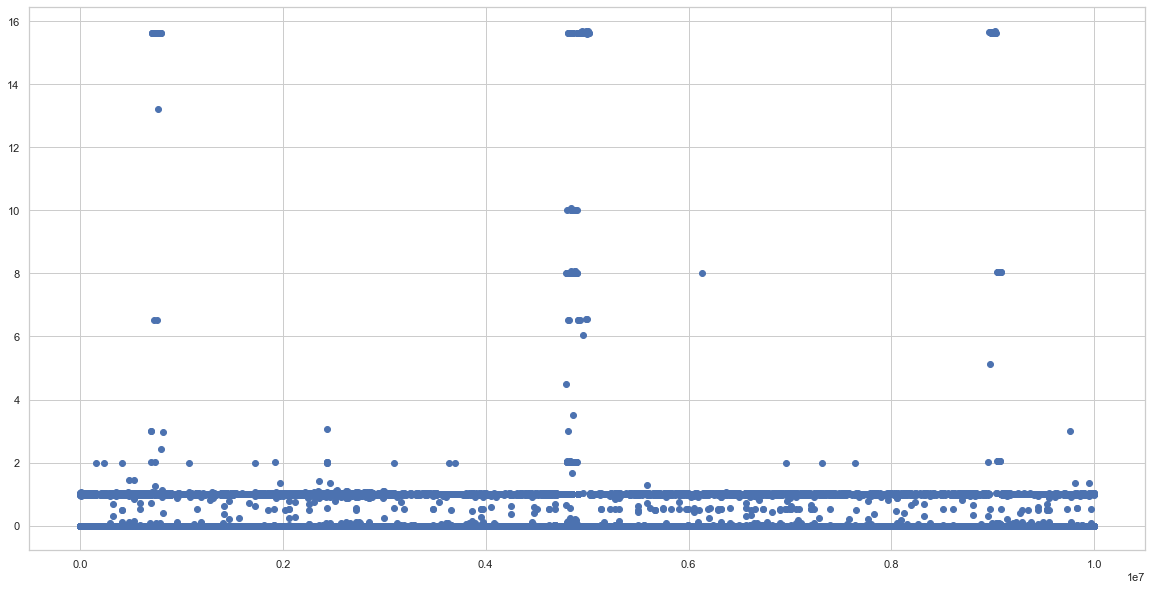

In [75]:
plt.scatter(num, search_time)
pass

### Deletion

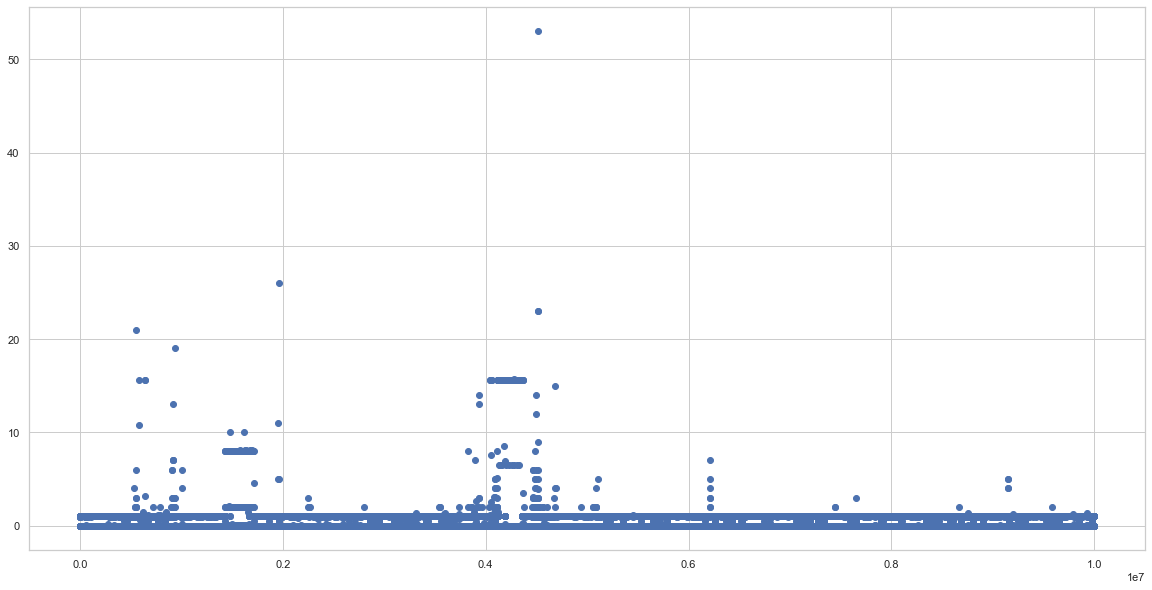

In [76]:
plt.scatter(num, delete_time)
pass

# Treap

In [38]:
insert_time, search_time, delete_time, _ = evaluate(trees.TreapInt(), unique_num_set)

Insert, Mean : 0.002683 ms.,  Max 15.781400 ms.
Search, Mean : 0.003901 ms.,  Max 28.003400 ms.
Delete, Mean : 0.021721 ms.,  Max 61.473400 ms.
Total time 295.636716, sec


### Insertion

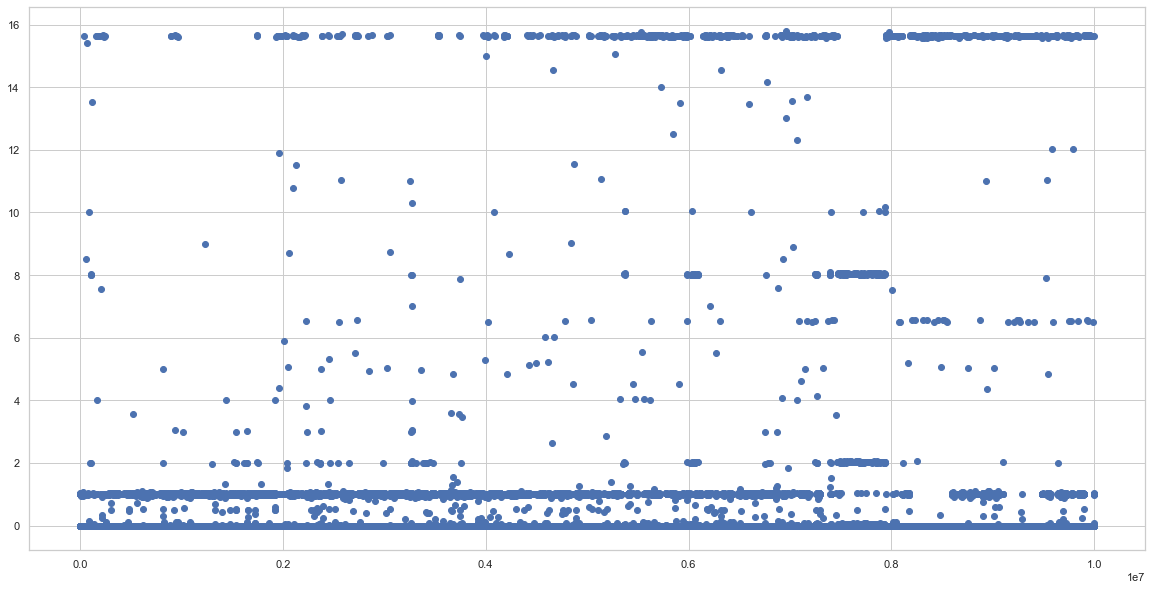

In [39]:
plt.scatter(num, insert_time)

pass

### Searching

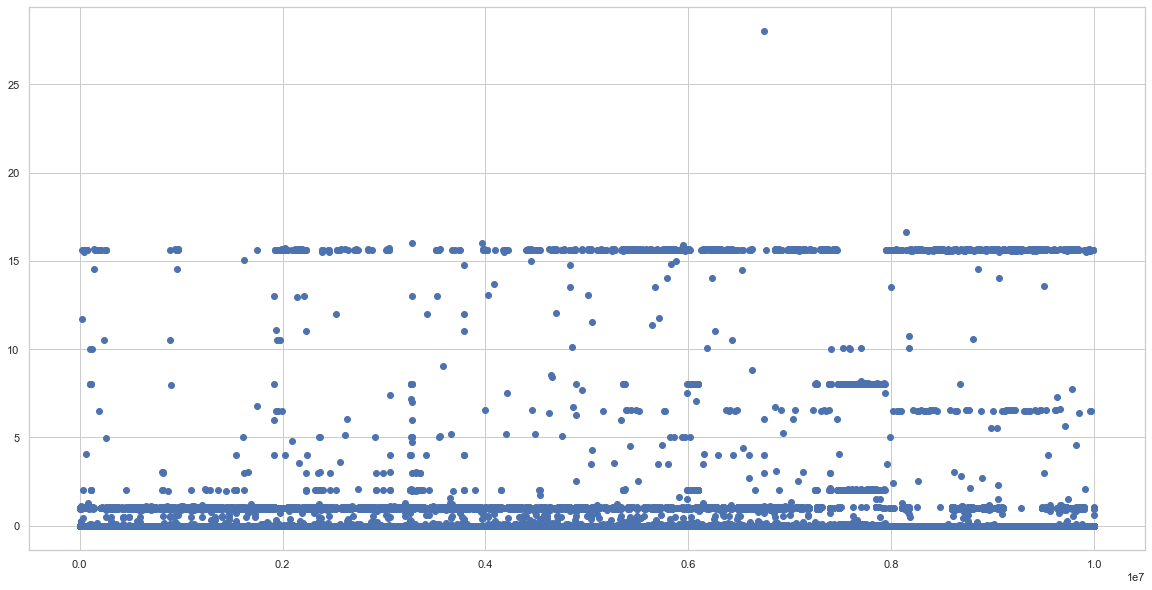

In [40]:
plt.scatter(num, search_time)
pass

### Deletion

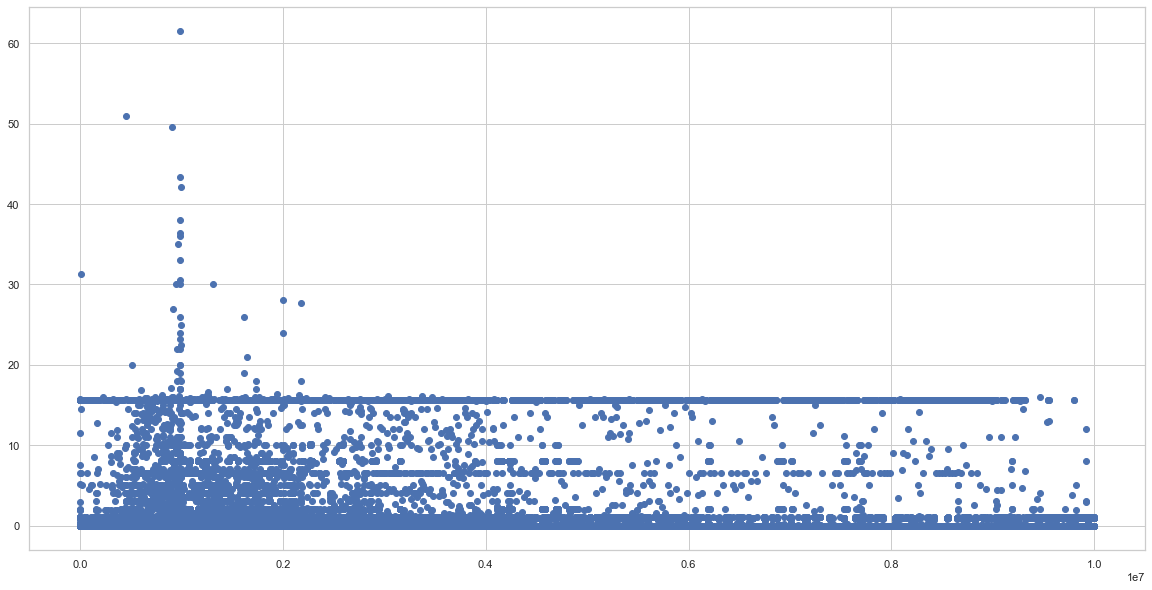

In [41]:
plt.scatter(num, delete_time)
pass

# Red-Black tree

In [ ]:
insert_time, search_time, delete_time, _ = evaluate(trees.RBTreeInt(), unique_num_set)

### Insertion

In [ ]:
plt.scatter(num, insert_time)
pass

### Searching

In [ ]:
plt.scatter(num, search_time)
pass

### Deletion

In [ ]:
plt.scatter(num, delete_time)
pass

# Sorted array

In [ ]:
insert_time, search_time, delete_time, _ = evaluate(trees.SortedArrInt(), unique_num_set)

### Insertion

In [ ]:
plt.scatter(num, insert_time)
pass

### Searching

In [ ]:
plt.scatter(num, search_time)
pass

### Deletion

In [ ]:
plt.scatter(num, delete_time)
pass